# Lab 5: Wide and Deep Networks

Ryan Schaefer

In [1]:
import pandas as pd
import numpy as np
import copy
import sys
import os
import contextlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics as mt
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import Recall
from tensorflow.keras.utils import FeatureSpace, plot_model
from tensorflow.keras.layers import Embedding, Concatenate, Flatten, Dense

pd.set_option('display.max_columns', None)

# Data Preparation

For this analysis, I will be using the heart disease health indicators dataset. The analysis task for this dataset is to classify if someone has a heart disease based on their responses to the Behavioral Risk Factor Surveillance System (BRFSS) survey, which is conducted anually by the CDC. A machine learning model could be used to screen patients who have filled out the survey so that the doctor only has to see patients who are likely to have heart disease. 

Dataset source:
- https://www.kaggle.com/datasets/alexteboul/heart-disease-health-indicators-dataset

In [2]:
df = pd.read_csv("../Datasets/heart_disease.csv")

df.head()

,HeartDiseaseorAttack,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,Diabetes,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

This dataset has already removed missing data and cleaned the original survey responses. The main preprocessing that needs to be done is changing the data types of the features to match if it is categorical or numeric data. The numeric features will be scaled and the categorical features will be embedded when we create the feature space later in this notebook.

In [4]:
# Make outcome an int
outcome = "HeartDiseaseorAttack"
df[outcome] = df[outcome].astype(int)

numeric_headers = [
    "BMI", "GenHlth", "MentHlth", "PhysHlth", "Age", "Education", "Income"
]

# Make categorical features strings
categorical_headers = [col for col in df.columns if col not in numeric_headers and col != outcome]
df[categorical_headers] = df[categorical_headers].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  int64  
 1   HighBP                253680 non-null  object 
 2   HighChol              253680 non-null  object 
 3   CholCheck             253680 non-null  object 
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  object 
 6   Stroke                253680 non-null  object 
 7   Diabetes              253680 non-null  object 
 8   PhysActivity          253680 non-null  object 
 9   Fruits                253680 non-null  object 
 10  Veggies               253680 non-null  object 
 11  HvyAlcoholConsump     253680 non-null  object 
 12  AnyHealthcare         253680 non-null  object 
 13  NoDocbcCost           253680 non-null  object 
 14  GenHlth               253680 non-null  float64
 15  

In [5]:
df.describe()

,HeartDiseaseorAttack,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000,253680.000000
mean,0.094186,28.382364,2.511392,3.184772,4.242081,8.032119,5.050434,6.053875
std,0.292087,6.608694,1.068477,7.412847,8.717951,3.054220,0.985774,2.071148
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,24.000000,2.000000,0.000000,0.000000,6.000000,4.000000,5.000000
50%,0.000000,27.000000,2.000000,0.000000,0.000000,8.000000,5.000000,7.000000
75%,0.000000,31.000000,3.000000,2.000000,3.000000,10.000000,6.000000,8.000000
max,1.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


In [6]:
# View the number and percentage of instances of each outcome class
display(df[outcome].value_counts())
df[outcome].value_counts() / len(df)

0    229787
1     23893
Name: HeartDiseaseorAttack, dtype: int64

0    0.905814
1    0.094186
Name: HeartDiseaseorAttack, dtype: float64

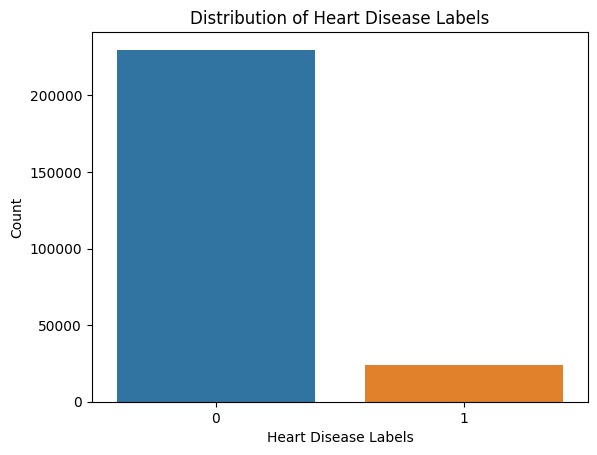

In [7]:
sns.countplot(data = df, x = outcome)

plt.title("Distribution of Heart Disease Labels")
plt.xlabel("Heart Disease Labels")
plt.ylabel("Count")

plt.show()

The bar graph above shows that there is a large class imbalance in the heart disease outcome feature. As this is a relatively large dataset (over 250,000 instances), we can use undersampling to balance the class distribution. There are just under 25,000 instances of class 1, meaning that an undersampled dataset would have just under 50,000 instances.

In [9]:
# Extract records of each outcome class
df_0 = df[df[outcome] == 0]
df_1 = df[df[outcome] == 1]
# Randomly sample class 0 instances of the same size as the number of class 1 instances
df_0 = df_0.sample(len(df_1), random_state = 7324)
# Concatenate class 0 and 1 instances and randomize
df_undersample = pd.concat([df_0, df_1]).sample(frac = 1, random_state = 7324).reset_index(drop = True)

df_undersample.describe()

,HeartDiseaseorAttack,BMI,GenHlth,MentHlth,PhysHlth,Age,Education,Income
count,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000,47786.000000
mean,0.500000,28.859624,2.893421,3.827397,6.436864,8.970912,4.917507,5.646947
std,0.500005,6.681145,1.157333,8.253928,10.535528,2.909753,1.031236,2.177845
min,0.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,24.000000,2.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,28.000000,3.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,32.000000,4.000000,2.000000,7.000000,11.000000,6.000000,8.000000
max,1.000000,98.000000,5.000000,30.000000,30.000000,13.000000,6.000000,8.000000


The descriptions of the features below are based on [the notebook that created this dataset](https://www.kaggle.com/code/alexteboul/heart-disease-health-indicators-dataset-notebook).

In [65]:
# Allow text to wrap to avoid cutting off descriptions
pd.set_option('display.max_colwidth', 0)

# Create data frame with feature descriptions
pd.DataFrame({
    "Feature": df_undersample.columns,
    "Description": [
        "Has the responder ever reported having coronary heart disease (CHD) or myocardial infarction (MI)",
        "Has the responder ever been told they have high blood pressure by a health professional",
        "Has the responder ever been told they have high blood cholesterol by a health professional",
        "Has the responder had their cholesterol checked in the past 5 years",
        "The responder's body mass index (BMI)",
        "Has the responder smoked at least 100 cigarettes (about 5 packs) in their lifetime",
        "Has the responder ever had a stroke",
        "Has the responder ever been diagnosed with diabetes (0 = no, 1 = pre- or borderline diabetees, 2 = yes)",
        "Does the responder do physical activity outside of their job",
        "Does the responder consume fruit at least once per day",
        "Does the responder consume vegetables at least once per day",
        "Is the responder a heavy drinker (14 and 7 drinks per week for men and women respectively)",
        "Does the responder have any kind of health care coverage",
        "Has the responder not seen a doctor when they needed to because of cost in the past year",
        "How does the responder rate their general health",
        "How many out of the past 30 would the responder say their mental health was not good",
        "How many out of the past 30 would the responder say their physical health was not good",
        "Does the responder have difficulty walking or climbing stairs",
        "What is the responder's gender (0 = female, 1 = male)",
        "What is the respondent's age on a 14 level scale (1 = 18-24, followed by 5 year intervals up to 13 = 80+)",
        "What is the highest grade of school the responder completed (1 = never attended school up to 6 = 4+ years of college)",
        "What is the responder's household income from all sources (1 = <$10,000 up to 8 = >$75,000)"
    ],
    "Discrete/Continuous": [
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Continuous",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Discrete",
        "Continuous",
        "Continuous",
        "Continuous",
        "Discrete",
        "Discrete",
        "Continuous",
        "Continuous",
        "Continuous"
    ],
    "Scale": [
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Ratio",
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Nominal",
        "Ratio",
        "Ratio",
        "Ratio",
        "Nominal",
        "Nominal",
        "Ratio",
        "Ratio",
        "Ratio"
    ],
    "Range": [
        repr(set(df_undersample["HeartDiseaseorAttack"])),
        repr(set(df_undersample["HighBP"])),
        repr(set(df_undersample["HighChol"])),
        repr(set(df_undersample["CholCheck"])),
        "12-98",
        repr(set(df_undersample["Smoker"])),
        repr(set(df_undersample["Stroke"])),
        repr(set(df_undersample["Diabetes"])),
        repr(set(df_undersample["PhysActivity"])),
        repr(set(df_undersample["Fruits"])),
        repr(set(df_undersample["Veggies"])),
        repr(set(df_undersample["HvyAlcoholConsump"])),
        repr(set(df_undersample["AnyHealthcare"])),
        repr(set(df_undersample["NoDocbcCost"])),
        "1-5",
        "0-30",
        "0-30",
        repr(set(df_undersample["DiffWalk"])),
        repr(set(df_undersample["Sex"])),
        "1-13",
        "1-6",
        "1-8"
    ]
})

,Feature,Description,Discrete/Continuous,Scale,Range
0,HeartDiseaseorAttack,Has the responder ever reported having coronary heart disease (CHD) or myocardial infarction (MI),Discrete,Nominal,"{0, 1}"
1,HighBP,Has the responder ever been told they have high blood pressure by a health professional,Discrete,Nominal,"{'1.0', '0.0'}"
2,HighChol,Has the responder ever been told they have high blood cholesterol by a health professional,Discrete,Nominal,"{'1.0', '0.0'}"
3,CholCheck,Has the responder had their cholesterol checked in the past 5 years,Discrete,Nominal,"{'1.0', '0.0'}"
4,BMI,The responder's body mass index (BMI),Continuous,Ratio,12-98
5,Smoker,Has the responder smoked at least 100 cigarettes (about 5 packs) in their lifetime,Discrete,Nominal,"{'1.0', '0.0'}"
6,Stroke,Has the responder ever had a stroke,Discrete,Nominal,"{'1.0', '0.0'}"
7,Diabetes,"Has the responder ever been diagnosed with diabetes (0 = no, 1 = pre- or borderline diabetees, 2 = yes)",Discrete,Nominal,"{'1.0', '2.0', '0.0'}"
8,PhysActivity,Does the responder do physical activity outside of their job,Discrete,Nominal,"{'1.0', '0.0'}"
9,Fruits,Does the responder consume fruit at least once per day,Discrete,Nominal,"{'1.0', '0.0'}"


## Categorical Crossing

There are a few categorical crossings that it may be useful for a model to memorize in the wide portion of the network. One crossing can represent someone's healthy habits. The features that could be included in this crossing are ```Smoker```, ```PhysActivity```, ```Fruits```, ```Veggies```, and ```HvyAlchoholConsump```. Another crossing can represent someone's medical history. The features that could be included in this crossing are ```HighBP```, ```HighChol```, ```Stroke```, and ```Diabetes```. A final crossing can represent someone's access to healthcare. The features that could be included in this crossing are ```AnyHealthcare``` and ```NoDocbcCost```.

## Evaluation Criteria

A classification model on this dataset would likely be used to screen potential patients based on their survey answers to determine if they need to see a doctor or not. In this use case, false positives are not a major concern, as it just means a few people will see the doctor when they are actually healthy. However, false negatives are a problem, as patients who have health disease will not see a doctor, meaning they will not be treated. To account for this, we can use recall as our evalutation criteria so that the models that minimize false negatives are considered the best models.

## Training/Testing Split

We can use K-Fold cross validation with 10 folds so that every instance is used in both the training and testing sets and give us a 90/10 training/testing split in every fold. The sample size is large enough that we do not need to use repeated cross validation. After undersampling, the distribution of the outcome class will be balanced, so we do not need to stratify the resampling.

In [10]:
cv = KFold(n_splits = 10)

# Modeling

## Create Feature Space

In [11]:
# create a tensorflow dataset, for ease of use later
batch_size = 64

def create_dataset_from_dataframe(df_input, outcome):
    df = df_input.copy()
    labels = df[outcome]
    features = list(df.columns)
    features.remove(outcome)

    df = {key: value.values[:,np.newaxis] for key, value in df_input[features].items()}

    # create the Dataset here
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    
    # now enable batching and prefetching
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    
    return ds

In [12]:
def extract_cross_validation_samples(df_input, outcome, cv):
    df = df_input.copy()
    y = df.pop(outcome)
    X = df
    ds_split = []
    for train, test in cv.split(X, y):
        ds_train = create_dataset_from_dataframe(df_input.loc[list(train)], outcome)
        ds_test = create_dataset_from_dataframe(df_input.loc[list(test)], outcome)
        ds_split.append((ds_train, ds_test))
        
    return ds_split

In [13]:
# Split data into 10 folds and convert to tensorflow dataset
ds_split = extract_cross_validation_samples(df_undersample, outcome, cv)
len(ds_split)

10

In [14]:
# Concatenate labels of folds into one array in the order of the folds
y_test = []
for ds_train, ds_test in ds_split:
    for x, y in ds_test:
        y_test.append(y)
y_test = tf.concat(y_test, axis = 0).numpy()
len(y_test)

47786

In [16]:
feature_space = FeatureSpace(
    features={
        # Categorical feature encoded as string
        "HighBP": FeatureSpace.string_categorical(num_oov_indices=0),
        "HighChol": FeatureSpace.string_categorical(num_oov_indices=0),
        "CholCheck": FeatureSpace.string_categorical(num_oov_indices=0),
        "Smoker": FeatureSpace.string_categorical(num_oov_indices=0),
        "Stroke": FeatureSpace.string_categorical(num_oov_indices=0),
        "Diabetes": FeatureSpace.string_categorical(num_oov_indices=0),
        "PhysActivity": FeatureSpace.string_categorical(num_oov_indices=0),
        "Fruits": FeatureSpace.string_categorical(num_oov_indices=0),
        "Veggies": FeatureSpace.string_categorical(num_oov_indices=0),
        "HvyAlcoholConsump": FeatureSpace.string_categorical(num_oov_indices=0),
        "AnyHealthcare": FeatureSpace.string_categorical(num_oov_indices=0),
        "NoDocbcCost": FeatureSpace.string_categorical(num_oov_indices=0),
        "DiffWalk": FeatureSpace.string_categorical(num_oov_indices=0),
        "Sex": FeatureSpace.string_categorical(num_oov_indices=0),
        
        # Numerical features to normalize (normalization will be learned)
        # learns the mean, variance, and if to invert (3 parameters)
        "BMI": FeatureSpace.float_normalized(),
        "GenHlth": FeatureSpace.float_normalized(),
        "MentHlth": FeatureSpace.float_normalized(),
        "PhysHlth": FeatureSpace.float_normalized(),
        "Age": FeatureSpace.float_normalized(),
        "Education": FeatureSpace.float_normalized(),
        "Income": FeatureSpace.float_normalized()
        
    },
    # Specify feature cross with a custom crossing dim
    crosses=[
        FeatureSpace.cross(
            feature_names=("Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"), 
            crossing_dim=2*2*2*2*2),
        FeatureSpace.cross(
            feature_names=("HighBP", "HighChol", "Stroke", "Diabetes"), 
            crossing_dim=2*2*2*2),
        FeatureSpace.cross(
            feature_names=("AnyHealthcare", "NoDocbcCost"), 
            crossing_dim=2*2)
    ],
    output_mode="concat",
)

train_ds_with_no_labels = ds_split[0][0].map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

The feature space above will number all levels of each categorical feature to prep them for embedding and normalize all numeric features. The crossings discussed above are also defined here.

## Model 1

In [17]:
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x # return the tensor here 

def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?
    
    # get the size of the feature
    N = feature_space.crossers[col_name].num_bins
    x = feature_space.crossers[col_name].output
    
    
    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col_name+'_embed')(x)
    
    x = Flatten()(x) # get rid of that pesky extra dimension (for time of embedding)
    
    return x


The first wide and deep network has 3 layers on the deep side and uses all of the crossings on the wide side.

In [18]:
dict_inputs = feature_space.get_inputs() # need to use unprocessed features here, to gain access to each output

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():
    
    x = setup_embedding_from_crossing(feature_space, col)
    
    # save these outputs in list to concatenate later
    crossed_outputs.append(x)
    

# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each numeric variable, just add it in after embedding
for idx,col in enumerate(numeric_headers):
    x = feature_space.preprocessors[col].output
    x = tf.cast(x,float) # cast an integer as a float here
    all_deep_branch_outputs.append(x)
    
# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)
    
    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)


# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=16,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=13,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
    
# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])

final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[Recall(name = "recall")]
)

training_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HighBP (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 HighChol (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 CholCheck (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Smoker (InputLayer)         [(None, 1)]                  0         []                            
                                                                                              

 rocessor (StringLookup)                                                                          
                                                                                                  
 string_categorical_14_prep  (None, 1)                    0         ['Sex[0][0]']                 
 rocessor (StringLookup)                                                                          
                                                                                                  
 float_normalized_1_preproc  (None, 1)                    3         ['BMI[0][0]']                 
 essor (Normalization)                                                                            
                                                                                                  
 float_normalized_2_preproc  (None, 1)                    3         ['GenHlth[0][0]']             
 essor (Normalization)                                                                            
          

 tf.cast_5 (TFOpLambda)      (None, 1)                    0         ['float_normalized_6_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 tf.cast_6 (TFOpLambda)      (None, 1)                    0         ['float_normalized_7_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 flatten_3 (Flatten)         (None, 1)                    0         ['HighBP_embed[0][0]']        
                                                                                                  
 flatten_4 (Flatten)         (None, 1)                    0         ['HighChol_embed[0][0]']      
                                                                                                  
 flatten_5

                                                                                                  
 Smoker_X_PhysActivity_X_Fr  (None, 1, 5)                 160       ['Smoker_X_PhysActivity_X_Frui
 uits_X_Veggies_X_HvyAlcoho                                         ts_X_Veggies_X_HvyAlcoholConsu
 lConsump_embed (Embedding)                                         mp[0][0]']                    
                                                                                                  
 HighBP_X_HighChol_X_Stroke  (None, 1, 4)                 64        ['HighBP_X_HighChol_X_Stroke_X
 _X_Diabetes_embed (Embeddi                                         _Diabetes[0][0]']             
 ng)                                                                                              
                                                                                                  
 AnyHealthcare_X_NoDocbcCos  (None, 1, 2)                 8         ['AnyHealthcare_X_NoDocbcCost[
 t_embed (

In [19]:
%%time

yhat_proba1 = []
history1 = {
    "recall": [],
    "val_recall": [],
    "loss": [],
    "val_loss": []
}

# Iterate through cross validation folds
for i, (ds_train, ds_test) in enumerate(ds_split):
    # Print fold number
    sys.stderr.write('\rFold: %d/%d' % (i+1, 10))
    sys.stderr.flush()

    # Fit model
    history = training_model.fit(
        ds_train, epochs=75, validation_data=ds_test, verbose=0
    )
            
    # Store model history
    history1["recall"].append(history.history["recall"])
    history1["val_recall"].append(history.history["val_recall"])
    history1["loss"].append(history.history["loss"])
    history1["val_loss"].append(history.history["val_loss"])
    
    # Store model predicted probabilities
    yhat_proba1.append(training_model.predict(ds_test, verbose = 0))
    
# Merge predicted probabilities for all folds
yhat_proba1 = [ prob[0] for probs in yhat_proba1 for prob in probs ]
# Take the mean of all history values for each epoch
for key in history1.keys():
    history1[key] = np.mean(history1[key], axis = 0)

Fold: 10/10

CPU times: user 18min 23s, sys: 5min 31s, total: 23min 54s
Wall time: 11min 22s


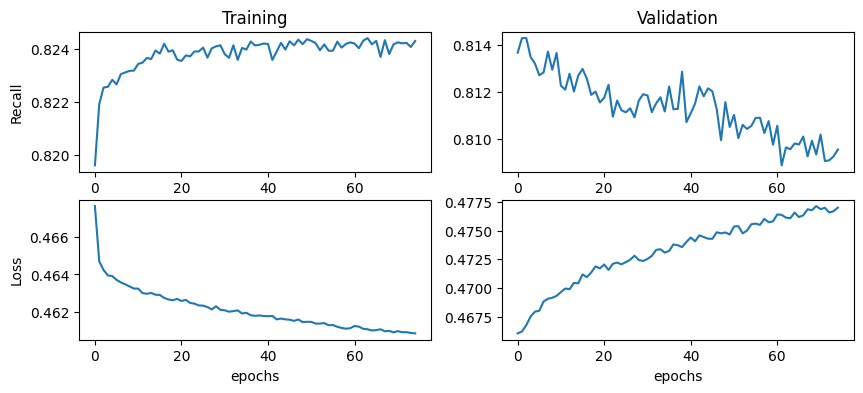

In [66]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history1['recall'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history1['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history1['loss'])
plt.ylabel('Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history1['val_loss'])
plt.xlabel('epochs')

plt.show()

The plots above show the mean recall and loss values of both the training and validations sets at each epoch across all folds. Although the training loss appears to converge, the validation loss increases with every epoch from the very beginning. This suggests that the model is overfitting to the training data. However, the validation loss never converges, suggesting there may be a problem with the model parameters or that there is not enough data for the model to converge.

In [21]:
# use squeeze to get rid of any extra dimensions 
yhat1 = np.round(yhat_proba1) # round to get binary class

print(mt.confusion_matrix(y_test,yhat1))
print(mt.classification_report(y_test,yhat1))

[[17701  6192]
 [ 4550 19343]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     23893
           1       0.76      0.81      0.78     23893

    accuracy                           0.78     47786
   macro avg       0.78      0.78      0.77     47786
weighted avg       0.78      0.78      0.77     47786



The mean recall score is 0.81, which suggests that the model is good at minimizing false negatives.

In [22]:
pd.Series(yhat1).value_counts() / len(yhat1)

1.0    0.534362
0.0    0.465638
dtype: float64

After undersampling, the distribution of each class should be 50/50. However, the model is predicting class 1 more frequently than class 0 (53.4% to 46.6%). 

## Model 2

For the second wide and deep network, I added 2 more layers to the deep side of the network for a total of 5 layers.

In [23]:
deep_branch2 = deep_branch
deep_branch2 = Dense(units=7,activation='relu', name='deep4')(deep_branch2)
deep_branch2 = Dense(units=4,activation='relu', name='deep5')(deep_branch2)

# merge the deep and wide branch
final_branch2 = Concatenate(name='concat_deep_wide')([deep_branch2, wide_branch])

final_branch2 = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch2)

training_model2 = keras.Model(inputs=dict_inputs, outputs=final_branch2)
training_model2.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[Recall(name = "recall")]
)

training_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HighBP (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 HighChol (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 CholCheck (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Smoker (InputLayer)         [(None, 1)]                  0         []                            
                                                                                            

 rocessor (StringLookup)                                                                          
                                                                                                  
 string_categorical_14_prep  (None, 1)                    0         ['Sex[0][0]']                 
 rocessor (StringLookup)                                                                          
                                                                                                  
 float_normalized_1_preproc  (None, 1)                    3         ['BMI[0][0]']                 
 essor (Normalization)                                                                            
                                                                                                  
 float_normalized_2_preproc  (None, 1)                    3         ['GenHlth[0][0]']             
 essor (Normalization)                                                                            
          

 tf.cast_5 (TFOpLambda)      (None, 1)                    0         ['float_normalized_6_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 tf.cast_6 (TFOpLambda)      (None, 1)                    0         ['float_normalized_7_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 flatten_3 (Flatten)         (None, 1)                    0         ['HighBP_embed[0][0]']        
                                                                                                  
 flatten_4 (Flatten)         (None, 1)                    0         ['HighChol_embed[0][0]']      
                                                                                                  
 flatten_5

                                                                     'string_categorical_12_prepro
                                                                    cessor[0][0]']                
                                                                                                  
 deep3 (Dense)               (None, 10)                   140       ['deep2[0][0]']               
                                                                                                  
 Smoker_X_PhysActivity_X_Fr  (None, 1, 5)                 160       ['Smoker_X_PhysActivity_X_Frui
 uits_X_Veggies_X_HvyAlcoho                                         ts_X_Veggies_X_HvyAlcoholConsu
 lConsump_embed (Embedding)                                         mp[0][0]']                    
                                                                                                  
 HighBP_X_HighChol_X_Stroke  (None, 1, 4)                 64        ['HighBP_X_HighChol_X_Stroke_X
 _X_Diabet

In [24]:
%%time

yhat_proba2 = []
history2 = {
    "recall": [],
    "val_recall": [],
    "loss": [],
    "val_loss": []
}

for i, (ds_train, ds_test) in enumerate(ds_split):
    sys.stderr.write('\rFold: %d/%d' % (i+1, 10))
    sys.stderr.flush()

    history = training_model2.fit(
        ds_train, epochs=75, validation_data=ds_test, verbose=0
    )
            
    history2["recall"].append(history.history["recall"])
    history2["val_recall"].append(history.history["val_recall"])
    history2["loss"].append(history.history["loss"])
    history2["val_loss"].append(history.history["val_loss"])
    
    yhat_proba2.append(training_model2.predict(ds_test, verbose = 0))
    
yhat_proba2 = [ prob[0] for probs in yhat_proba2 for prob in probs ]
for key in history2.keys():
    history2[key] = np.mean(history2[key], axis = 0)

Fold: 10/10

CPU times: user 18min 53s, sys: 5min 40s, total: 24min 33s
Wall time: 12min 1s


Text(0.5, 0, 'epochs')

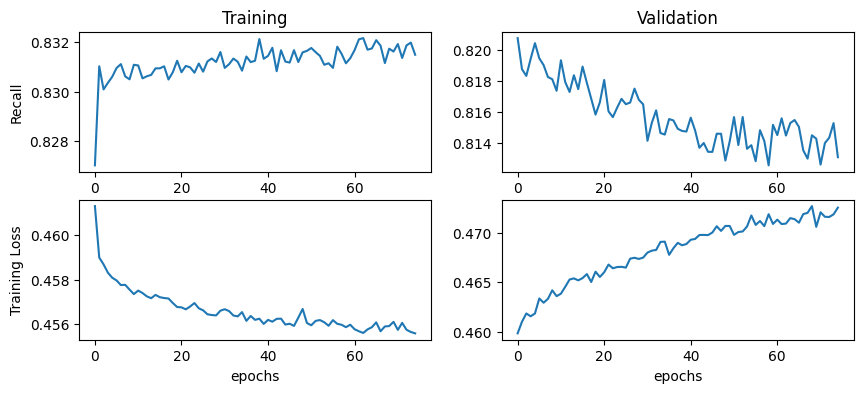

In [25]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history2['recall'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history2['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history2['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history2['val_loss'])
plt.xlabel('epochs')

The training and validation losses show the same trends as the first model, where the training loss converges but the validation loss does not.

In [26]:
# use squeeze to get rid of any extra dimensions 
yhat2 = np.round(yhat_proba2) # round to get binary class

print(mt.confusion_matrix(y_test,yhat2))
print(mt.classification_report(y_test,yhat2))

[[17765  6128]
 [ 4465 19428]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     23893
           1       0.76      0.81      0.79     23893

    accuracy                           0.78     47786
   macro avg       0.78      0.78      0.78     47786
weighted avg       0.78      0.78      0.78     47786



In [27]:
pd.Series(yhat2).value_counts() / len(yhat2)

1.0    0.534801
0.0    0.465199
dtype: float64

The mean recall score and distribution of predicted classes are very similar to model 1, but we cannot determine if the models are approximately the same or not without a statistical test.

### Comparing Models 1 and 2

The McNemar test is a statistical test for the null hypothesis that two models predict approximately the same and the alternate hypothesis that two models predict differently. If the models are found to be the same, then we can choose either model. If the models are found to be different, then we should choose the model with the higher recall score. At the 0.05 significance level, the test statistic must exceed 3.841 for us to reject the null hypothesis.

In [28]:
# Function to conduct the McNemar test for 2 sets of predictions
# Returns true if we reject the null hypothesis (the models are different)
def mcnemar_test(y, yhat1, yhat2):
    # Calculate B and C
    B = 0
    C = 0
    for i in range(len(y)):
        # If yhat1 and yhat2 match, then neither B nor C
        if yhat1[i] == yhat2[i]:
            continue
        else:
            # If yhat1 and y match, then B
            if y[i] == yhat1[i]:
                B += 1
            # Else, C
            else:
                C += 1
    
    # Calculate test statistic
    x2 = ((abs(B - C) - 1) ** 2) / (B + C)
    print(x2)
    
    # Determine if we should reject the null hypothesis or not
    return x2 > 3.841

In [29]:
mcnemar_test(y_test, yhat1, yhat2)

8.401994629842731


True

The test statistic from the McNemar test is 8.4, so we reject the null hypothesis and conclude that the models predict differently. We will choose the model with the larger recall score.

In [30]:
print("Model 1 recall:", mt.recall_score(y_test, yhat1))
print("Model 2 recall:", mt.recall_score(y_test, yhat2))

Model 1 recall: 0.8095676557987695
Model 2 recall: 0.8131251831080233


Model 2 produced the larger recall score, so we will conclude that it is the better of the two models.

## Model 3

For the third and final wide and deep network, I added a second layer to the merged branch of the network to help the model choose how to combine the wide and deep branches. 

In [31]:
# merge the deep and wide branch
final_branch3 = Concatenate(name='concat_deep_wide')([deep_branch2, wide_branch])

final_branch3 = Dense(units=5,activation='relu',
                     name='combined1')(final_branch3)
final_branch3 = Dense(units=1,activation='sigmoid',
                     name='combined2')(final_branch3)

training_model3 = keras.Model(inputs=dict_inputs, outputs=final_branch3)
training_model3.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[Recall(name = "recall")]
)

training_model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HighBP (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 HighChol (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 CholCheck (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Smoker (InputLayer)         [(None, 1)]                  0         []                            
                                                                                            

 rocessor (StringLookup)                                                                          
                                                                                                  
 string_categorical_14_prep  (None, 1)                    0         ['Sex[0][0]']                 
 rocessor (StringLookup)                                                                          
                                                                                                  
 float_normalized_1_preproc  (None, 1)                    3         ['BMI[0][0]']                 
 essor (Normalization)                                                                            
                                                                                                  
 float_normalized_2_preproc  (None, 1)                    3         ['GenHlth[0][0]']             
 essor (Normalization)                                                                            
          

 tf.cast_5 (TFOpLambda)      (None, 1)                    0         ['float_normalized_6_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 tf.cast_6 (TFOpLambda)      (None, 1)                    0         ['float_normalized_7_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 flatten_3 (Flatten)         (None, 1)                    0         ['HighBP_embed[0][0]']        
                                                                                                  
 flatten_4 (Flatten)         (None, 1)                    0         ['HighChol_embed[0][0]']      
                                                                                                  
 flatten_5

                                                                     'string_categorical_12_prepro
                                                                    cessor[0][0]']                
                                                                                                  
 deep3 (Dense)               (None, 10)                   140       ['deep2[0][0]']               
                                                                                                  
 Smoker_X_PhysActivity_X_Fr  (None, 1, 5)                 160       ['Smoker_X_PhysActivity_X_Frui
 uits_X_Veggies_X_HvyAlcoho                                         ts_X_Veggies_X_HvyAlcoholConsu
 lConsump_embed (Embedding)                                         mp[0][0]']                    
                                                                                                  
 HighBP_X_HighChol_X_Stroke  (None, 1, 4)                 64        ['HighBP_X_HighChol_X_Stroke_X
 _X_Diabet

In [35]:
%%time

yhat_proba3 = []
history3 = {
    "recall": [],
    "val_recall": [],
    "loss": [],
    "val_loss": []
}

for i, (ds_train, ds_test) in enumerate(ds_split):
    sys.stderr.write('\rFold: %d/%d' % (i+1, 10))
    sys.stderr.flush()

    history = training_model3.fit(
        ds_train, epochs=75, validation_data=ds_test, verbose=0
    )
            
    history3["recall"].append(history.history["recall"])
    history3["val_recall"].append(history.history["val_recall"])
    history3["loss"].append(history.history["loss"])
    history3["val_loss"].append(history.history["val_loss"])
    
    yhat_proba3.append(training_model3.predict(ds_test, verbose = 0))
    
yhat_proba3 = [ prob[0] for probs in yhat_proba3 for prob in probs ]
for key in history3.keys():
    history3[key] = np.mean(history3[key], axis = 0)

Fold: 10/10

CPU times: user 19min 25s, sys: 5min 26s, total: 24min 52s
Wall time: 12min 13s


Text(0.5, 0, 'epochs')

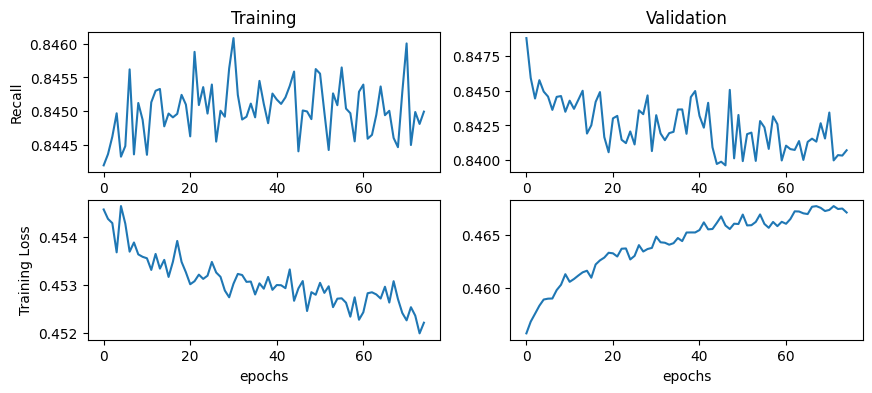

In [36]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history3['recall'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history3['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history3['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history3['val_loss'])
plt.xlabel('epochs')

The plots above show the same trends in the training and validation loss as models 1 and 2.

In [37]:
# use squeeze to get rid of any extra dimensions 
yhat3 = np.round(yhat_proba3) # round to get binary class

print(mt.confusion_matrix(y_test,yhat3))
print(mt.classification_report(y_test,yhat3))

[[17133  6760]
 [ 3801 20092]]
              precision    recall  f1-score   support

           0       0.82      0.72      0.76     23893
           1       0.75      0.84      0.79     23893

    accuracy                           0.78     47786
   macro avg       0.78      0.78      0.78     47786
weighted avg       0.78      0.78      0.78     47786



Model 3 appears to have a larger recall score than models 1 and 2 (0.84 vs 0.81), suggesting that this may be the best model (subject to the results of the McNemar test).

In [38]:
pd.Series(yhat3).value_counts() / len(yhat3)

1.0    0.561922
0.0    0.438078
dtype: float64

Model 3 predicts class 1 more frequently than models 1 and 2 (56% vs 53%). This possibly reduces the overall accuracy of the model, since class 1 should appear in 50% of the instances, but also could explain the increase in recall score. If class 1 is predicted more frequently, then it is less likely to have a false negative (predicting 0 when it should be 1).

### Comparing Models 2 and 3

In [39]:
mcnemar_test(y_test, yhat2, yhat3)

0.31343770384866276


False

In [41]:
print("Model 2 recall:", mt.recall_score(y_test, yhat2))
print("Model 3 recall:", mt.recall_score(y_test, yhat3))

Model 2 recall: 0.8131251831080233
Model 3 recall: 0.8409157493826643


The test statistics of the McNemar test is 0.3, so we fail to reject the null hypothesis and conclude that models 2 and 3 are approximately the same. Although model 2 is the simpler of the two models, model 3 increases the recall score by a larger margin than models 1 and 2, despite those models being concluded as different. Model 3 may have more false positives due to predicting class 1 more frequently than expected, but false positives are not a concern for how this model will be used. Thus, we will consider model 3 as the best wide and deep network for this use case.

# Deep Network Comparison

### Fit Deep Network

We can compare the best wide and deep network (model 3) to a model with just the 5 layer deep side of the network.

In [47]:
final_branch_deep = Dense(units=1,activation='sigmoid',
                     name='combined')(deep_branch2)

training_model_deep = keras.Model(inputs=dict_inputs, outputs=final_branch_deep)
training_model_deep.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[Recall(name = "recall")]
)

training_model_deep.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HighBP (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 HighChol (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 CholCheck (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Smoker (InputLayer)         [(None, 1)]                  0         []                            
                                                                                            

 rocessor (StringLookup)                                                                          
                                                                                                  
 string_categorical_14_prep  (None, 1)                    0         ['Sex[0][0]']                 
 rocessor (StringLookup)                                                                          
                                                                                                  
 float_normalized_1_preproc  (None, 1)                    3         ['BMI[0][0]']                 
 essor (Normalization)                                                                            
                                                                                                  
 float_normalized_2_preproc  (None, 1)                    3         ['GenHlth[0][0]']             
 essor (Normalization)                                                                            
          

 tf.cast_5 (TFOpLambda)      (None, 1)                    0         ['float_normalized_6_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 tf.cast_6 (TFOpLambda)      (None, 1)                    0         ['float_normalized_7_preproces
                                                                    sor[0][0]']                   
                                                                                                  
 flatten_3 (Flatten)         (None, 1)                    0         ['HighBP_embed[0][0]']        
                                                                                                  
 flatten_4 (Flatten)         (None, 1)                    0         ['HighChol_embed[0][0]']      
                                                                                                  
 flatten_5

In [48]:
%%time

yhat_proba_deep = []
history_deep = {
    "recall": [],
    "val_recall": [],
    "loss": [],
    "val_loss": []
}

for i, (ds_train, ds_test) in enumerate(ds_split):
    sys.stderr.write('\rFold: %d/%d' % (i+1, 10))
    sys.stderr.flush()

    history = training_model_deep.fit(
        ds_train, epochs=75, validation_data=ds_test, verbose=0
    )
            
    history_deep["recall"].append(history.history["recall"])
    history_deep["val_recall"].append(history.history["val_recall"])
    history_deep["loss"].append(history.history["loss"])
    history_deep["val_loss"].append(history.history["val_loss"])
    
    yhat_proba_deep.append(training_model_deep.predict(ds_test, verbose = 0))
    
yhat_proba_deep = [ prob[0] for probs in yhat_proba_deep for prob in probs ]
for key in history_deep.keys():
    history_deep[key] = np.mean(history_deep[key], axis = 0)

Fold: 10/10

CPU times: user 16min 17s, sys: 5min 58s, total: 22min 16s
Wall time: 10min 10s


Text(0.5, 0, 'epochs')

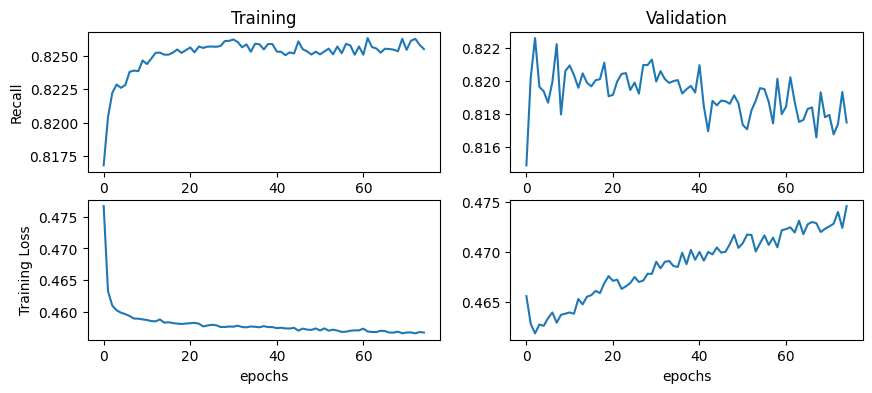

In [49]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history_deep['recall'])

plt.ylabel('Recall')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history_deep['val_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history_deep['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history_deep['val_loss'])
plt.xlabel('epochs')

The plots above show the same trends in the training and validation loss. However, the training loss appears to converge must faster than the wide and deep networks.

In [50]:
# use squeeze to get rid of any extra dimensions 
yhat_deep = np.round(yhat_proba_deep) # round to get binary class

print(mt.confusion_matrix(y_test,yhat_deep))
print(mt.classification_report(y_test,yhat_deep))

[[17765  6128]
 [ 4360 19533]]
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     23893
           1       0.76      0.82      0.79     23893

    accuracy                           0.78     47786
   macro avg       0.78      0.78      0.78     47786
weighted avg       0.78      0.78      0.78     47786



The deep network produces a larger recall score than models 1 and 2 (0.82 to 0.81), but a smaller recall score than model 3 (0.82 to 0.84).

In [51]:
pd.Series(yhat_deep).value_counts() / len(yhat_deep)

1.0    0.536998
0.0    0.463002
dtype: float64

The deep network predicts class 1 at about the same rate as models 1 and 2 (about 53%), but less frequently than model 3 (53% to 56%).

### McNemar Test

In [56]:
mcnemar_test(y_test, yhat3, yhat_deep)

1.400702512834369


False

The test statistic of the McNemar test comparing the deep network to model 3 is 1.4, so we fail to reject the null hypothesis and conclude that the models are approximately the same.

In [57]:
print("Wide and Deep network recall:", mt.recall_score(y_test, yhat3))
print("Deep network recall:", mt.recall_score(y_test, yhat_deep))

Wide and Deep network recall: 0.8409157493826643
Deep network recall: 0.8175197756665132


### ROC Curve

Another way we can compare these models is with the receiver operating characteristic (ROC) curve. The ROC curve plots a model's true positve rate against the false positive rate using different thresholds on the predicted probabilities. The area under the ROC curve (AUC) can be used to assess the fit of a model, where a larger AUC suggests a better fit).

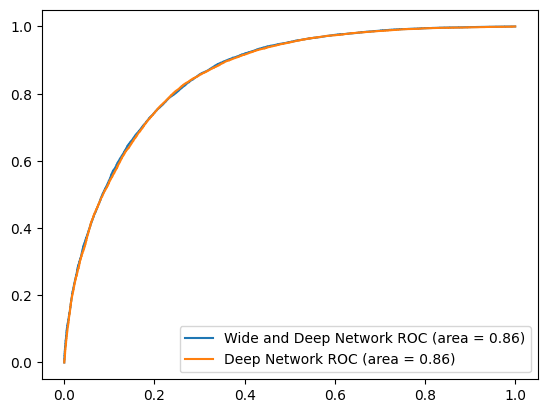

In [58]:
# Wide and deep network
fpr_wide, tpr_wide, thresholds_wide = mt.roc_curve(
    y_test,
    yhat_proba3,
    pos_label=1
)
auc_wide = mt.auc(fpr_wide, tpr_wide)
plt.plot(
    fpr_wide,
    tpr_wide,
    label='Wide and Deep Network ROC (area = %0.2f)' % (auc_wide)
)

# Deep network
fpr_deep, tpr_deep, thresholds_deep = mt.roc_curve(
    y_test,
    yhat_proba_deep,
    pos_label=1
)
auc_deep = mt.auc(fpr_deep, tpr_deep)
plt.plot(
    fpr_deep,
    tpr_deep,
    label='Deep Network ROC (area = %0.2f)' % (auc_deep)
)

plt.legend()
plt.show()

In [67]:
print("Wide and Deep network AUC:", auc_wide)
print("Deep network AUC:", auc_deep)

Wide and Deep network AUC: 0.857355126862357
Deep network AUC: 0.8558206616799175


The ROC curves for the deep and wide and deep networks look almost identical and have approximately the same AUC score (0.856 to 0.857). This agrees with the results of the McNemar test that the models are approximately the same.

## Embedding Weights

We can plot the embedding weights for each class in each categorical feature to look for clusters that may give us insight into which features are related. To visualize this, we will embed the features into 2 dimensions instead of calculating the number of dimensions based on how many classes there are.

In [59]:
def setup_embedding_from_categorical2(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    N = len(feature_space.preprocessors[col_name].get_vocabulary())
    
    # get the output from the feature space, which is input to embedding
    x = feature_space.preprocessors[col_name].output
    
    # now use an embedding to deal with integers from feature space
    x = Embedding(input_dim=N, 
                  output_dim=2, 
                  input_length=1, name=col_name+'_embed')(x)
    
    return x # return the tensor here 

In [60]:
# reset this input branch
embedding_outputs = []

# for each categorical variable
for col in categorical_headers:
    
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical2(feature_space, col)
    
    # save these outputs in list to concatenate later
    embedding_outputs.append(x)
    
embedding_branch = Concatenate(name='embed_concat')(embedding_outputs)
final_branch_embedding = Dense(units=1,activation='sigmoid',
                     name='combined')(embedding_branch)

training_model_embedding = keras.Model(inputs=dict_inputs, outputs=final_branch_embedding)
training_model_embedding.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=[Recall(name = "recall")]
)

training_model_embedding.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 HighBP (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 HighChol (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 CholCheck (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Smoker (InputLayer)         [(None, 1)]                  0         []                            
                                                                                            

 Smoker_embed (Embedding)    (None, 1, 2)                 4         ['string_categorical_4_preproc
                                                                    essor[0][0]']                 
                                                                                                  
 Stroke_embed (Embedding)    (None, 1, 2)                 4         ['string_categorical_5_preproc
                                                                    essor[0][0]']                 
                                                                                                  
 Diabetes_embed (Embedding)  (None, 1, 2)                 6         ['string_categorical_6_preproc
                                                                    essor[0][0]']                 
                                                                                                  
 PhysActivity_embed (Embedd  (None, 1, 2)                 4         ['string_categorical_7_preproc
 ing)     

In [61]:
embedding_weights = []
for col in categorical_headers:
    layer = col + "_embed"
    w = training_model_embedding.get_layer(layer).get_weights()[0]
    embedding_weights.append(w)
embedding_weights

[array([[ 0.0379512 ,  0.0292013 ],
        [-0.00061185, -0.02078108]], dtype=float32),
 array([[ 0.04049364,  0.00611459],
        [-0.02475323,  0.0371814 ]], dtype=float32),
 array([[ 0.01668933, -0.03614061],
        [ 0.01875034,  0.02539226]], dtype=float32),
 array([[-0.01492606, -0.03525778],
        [-0.04486321, -0.03709766]], dtype=float32),
 array([[-0.03513298, -0.04334844],
        [ 0.04417808,  0.01468689]], dtype=float32),
 array([[-0.03790158, -0.0454757 ],
        [ 0.03142854,  0.00950208],
        [-0.02254345,  0.01845671]], dtype=float32),
 array([[ 0.01636858, -0.00402917],
        [-0.00751334,  0.01063157]], dtype=float32),
 array([[ 0.03428358,  0.03497377],
        [ 0.00174345, -0.03505059]], dtype=float32),
 array([[-0.01931951, -0.04465951],
        [ 0.02346059,  0.02162347]], dtype=float32),
 array([[ 0.02982656,  0.02569019],
        [ 0.04658005, -0.0125577 ]], dtype=float32),
 array([[-0.04832213,  0.02617428],
        [ 0.04742422,  0.01658008]], d

In [62]:
w1 = []
w2 = []
f = []
for i, weights in enumerate(embedding_weights):
    feature = categorical_headers[i]
    categories = feature_space.preprocessors[feature].get_vocabulary()
    for j, weight in enumerate(weights):
        w1.append(weight[0])
        w2.append(weight[1])
        category = int(float(categories[j]))
        f.append("{}_{}".format(feature, category))
        
df_embeddings = pd.DataFrame({
    "embedding1": w1,
    "embedding2": w2,
    "feature_category": f
})

df_embeddings

,embedding1,embedding2,feature_category
0,0.037951,0.029201,HighBP_1
1,-0.000612,-0.020781,HighBP_0
2,0.040494,0.006115,HighChol_1
3,-0.024753,0.037181,HighChol_0
4,0.016689,-0.036141,CholCheck_1
5,0.018750,0.025392,CholCheck_0
6,-0.014926,-0.035258,Smoker_1
7,-0.044863,-0.037098,Smoker_0
8,-0.035133,-0.043348,Stroke_0
9,0.044178,0.014687,Stroke_1


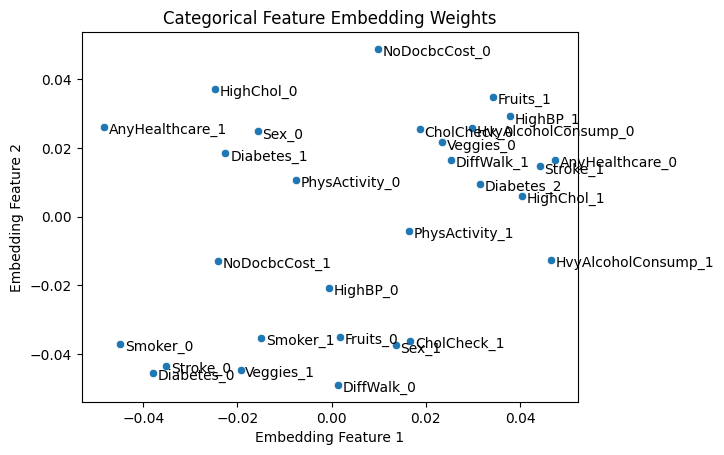

In [63]:
# Graphing code based on: 
# https://stackoverflow.com/questions/46027653/adding-labels-in-x-y-scatter-plot-with-seaborn

p1 = sns.scatterplot(
    x='embedding1',
    y='embedding2',
    data=df_embeddings,
    legend=False
)  

for line in range(0, df_embeddings.shape[0]):
     p1.text(
         df_embeddings["embedding1"][line]+0.001, 
         df_embeddings["embedding2"][line]-0.002, 
         df_embeddings["feature_category"][line], 
         horizontalalignment='left', 
         size='medium', 
         color='black'
    )

plt.title('Categorical Feature Embedding Weights')
plt.xlabel('Embedding Feature 1')
plt.ylabel('Embedding Feature 2')

plt.show()

The plot above shows the 2-dimensional embedding weights for each class in each categorical features. There are several clusters of feature classes that the model views similarly.

- There is a cluster in the bottom left corner that includes ```Smoker_0```, ```Stroke_0```, ```Diabetes_0```, and ```Veggies_1```. All of the feature classes in this cluster are associated with healthy people and healthy lifestyles. People who fall under these feature classes do not smoke, eat vegetables regularly, and have never had a stroke or diabetes.
- There is a cluster in the top left corner that includes ```HighChol_0```, ```AnyHealthcare_1```, ```Sex_0```, ```Diabetes_1```, and ```PhysActivity_0```. ```Sex_0``` corresponds to women, so it is interesting that the model associates women with not having high cholesterol, not doing much physical activity outside of work, having some form of healthcare, and having pre-diabetes or borderline diabetes. 
- There is a small cluster in the bottom middle that includes ```Sex_1```, ```CholCheck_1```, and ```Fruits_0```. ```Sex_1``` corresponds to men, so the model associates having cholesterol checked and not eating fruits regularly.
- There is a large cluster in the top right corner that includes ```Fruits_1```, ```HighBP_1```, ```CholCheck_0```, ```Hvy_AlcoholConsump_0```, ```Veggies_0```, ```DiffWalk_1```, ```AnyHealthcare_0```, ```Stroke_1```, ```Diabetes_2```, and ```HighChol_1```. Several of these feature classes are associated with having health problems, like having high blood pressure, high cholesterol, having a stroke, having diabetes, and having difficulty walking. Others are associated with unhealthy habbits, like not having healthcare and not eating vegetables regularly. However, it is interesting that eating fruits regularly and not drinking alcohol heavily are also part of this cluster, as these would normally be seen as healthier habits. It is also interesting that not checking cholesterol is part of this cluster with having high cholesterol.